In [1]:
import pandas as pd
import requests
from datetime import datetime
import re

In [348]:
import geopandas as gpd

In [278]:
from sklearn.preprocessing import StandardScaler

In [279]:
from sklearn.cluster import KMeans

In [95]:
import numpy as np

In [2]:
from config import cc_api_key

In [291]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

In [296]:
from scipy.cluster.hierarchy import fcluster

In [357]:
import folium

In [385]:
from folium.features import GeoJsonTooltip

In [3]:
TODAY = datetime.today()
SESS_BEGIN = TODAY.replace(year=TODAY.year - ((TODAY.year % 4) - 2), month=1, day=1).strftime("%Y-%m-%d") if (TODAY.year % 4) >= 2 else TODAY.replace(year=TODAY.year - ((TODAY.year % 4) + 2), month=1, day=1).strftime("%Y-%m-%d")
SESS_END = "{}-{}-{}".format(int(SESS_BEGIN.split("-")[0]) + 3, 12, 31)

In [147]:
SESS_BEGIN

'2022-01-01'

In [328]:
def process_cm_info(df):
    CM_RAW = df.json()

    for CM in CM_RAW:
        PERSON_DATA = requests.get(url="https://webapi.legistar.com/v1/nyc/Persons/{}/?&token={}".format(CM["OfficeRecordPersonId"], cc_api_key))
        CM_PERSONAL_DATA = PERSON_DATA.json()


        if CM_PERSONAL_DATA['PersonWWW']:
            district_numbers = re.findall('[0-9]+', CM_PERSONAL_DATA['PersonWWW'])
            if district_numbers:
                CM["District"] = int(district_numbers[0])
            else:
                if CM_PERSONAL_DATA['PersonEmail']:
                    district_numbers = re.findall('[0-9]+', CM_PERSONAL_DATA['PersonEmail'])
                    CM["District"] = int(district_numbers[0]) if district_numbers else np.nan
                else:
                    CM["District"] = np.nan
        else:
            CM["District"] = np.nan

        CM['Address'] = CM_PERSONAL_DATA['PersonAddress1']
        CM["City"] = CM_PERSONAL_DATA['PersonCity1']
        CM['Zip'] = CM_PERSONAL_DATA['PersonZip1']

    CM_DATA = sorted(CM_RAW, key=lambda i: i['District'] if not np.isnan(i['District']) else float('inf'))

    return pd.DataFrame(CM_DATA)

In [341]:
def generate_cc_df():
    CM_RAW = requests.get(url="https://webapi.legistar.com/v1/nyc/Bodies/1/OfficeRecords/?$filter=OfficeRecordStartDate+eq+datetime'{}'&token={}".format(SESS_BEGIN, cc_api_key))

    CM_DATA = process_cm_info(CM_RAW)

    CM_DATA.loc[CM_DATA['OfficeRecordFullName'] == 'Joseph C. Borelli', 'District'] = 51
    CM_DATA.loc[CM_DATA['OfficeRecordFullName'] == 'Justin L. Brannan', 'District'] = 43
    CM_DATA = CM_DATA[CM_DATA['OfficeRecordFullName'] != 'Public Advocate Jumaane Williams']
    CM_DATA['District'] = CM_DATA['District'].astype('Int64')

    return CM_DATA
    

In [4]:
def fetch_info(subject,api_key):
    url = f"https://webapi.legistar.com/v1/nyc/{subject}/?token={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return pd.DataFrame(data)
    else:
        print("Failed to fetch data:", response.status_code)
        print("Response text:", response.text)
        return None

In [306]:
CM_RAW = requests.get(url="https://webapi.legistar.com/v1/nyc/Bodies/1/OfficeRecords/?$filter=OfficeRecordStartDate+eq+datetime'{}'&token={}".format(SESS_BEGIN, cc_api_key))

In [329]:
CM_DATA = process_cm_info(CM_RAW)

In [337]:
CM_DATA.loc[CM_DATA['OfficeRecordFullName'] == 'Joseph C. Borelli', 'District'] = 51
CM_DATA.loc[CM_DATA['OfficeRecordFullName'] == 'Justin L. Brannan', 'District'] = 43

In [335]:
#Drop Jumanee Williams
CM_DATA = CM_DATA[CM_DATA['OfficeRecordFullName'] != 'Public Advocate Jumaane Williams']

In [339]:
#Make district Int64
CM_DATA['District'] = CM_DATA['District'].astype('Int64')

In [340]:
CM_DATA[['OfficeRecordFullName', 'District', 'Address', 'City', 'Zip']]

OfficeRecordFullName  District  \
0           Christopher Marte         1   
1             Carlina Rivera          2   
2            Erik D. Bottcher         3   
3               Keith Powers          4   
4                 Julie Menin         5   
5              Gale A. Brewer         6   
6                 Shaun Abreu         7   
7              Diana I. Ayala         8   
8   Kristin Richardson Jordan         9   
9        Carmen N. De La Rosa        10   
10              Eric Dinowitz        11   
11             Kevin C. Riley        12   
12         Marjorie Velázquez        13   
13        Pierina Ana Sanchez        14   
14               Oswald Feliz        15   
15         Althea V.  Stevens        16   
16      Rafael Salamanca, Jr.        17   
17              Amanda Farías        18   
18            Vickie Paladino        19   
19                 Sandra Ung        20   
20          Francisco P. Moya        21   
21              Tiffany Cabán        22   
22                  Linda Lee        23   
23           James F. Gennaro        24   
24            Shekar Krishnan        25   
25                  Julie Won        26   
26       Nantasha M. Williams        27   
27          Adrienne E. Adams        28   
28           Lynn C. Schulman        29   
29           Robert F. Holden        30   
30   Selvena N. Brooks-Powers        31   
31              Joann Ariola         32   
32            Lincoln Restler        33   
33         Jennifer Gutiérrez        34   
34             Crystal Hudson        35   
35                Chi A. Ossé        36   
36                Sandy Nurse        37   
37               Alexa Avilés        38   
38           Shahana K. Hanif        39   
39             Rita C. Joseph        40   
40              Darlene Mealy        41   
41             Charles Barron        42   
42              Kalman Yeger         44   
43             Farah N. Louis        45   
44          Mercedes Narcisse        46   
45                  Ari Kagan        47   
46              Inna Vernikov        48   
47             Kamillah Hanks        49   
48              David M. Carr        50   
49          Joseph C. Borelli        51   
50          Justin L. Brannan        43   

                                              Address                 City  \
0                                    65 East Broadway             New York   
1                                 254 East 4th Street             New York   
2                        224 West 30th St, Suite 1206             New York   
3                    211 East 43rd Street, Suite 1205             New York   
4                                444 East 75th Street             New York   
5                   563 Columbus Ave (at 87th Street)             New York   
6                               500 West 141st Street             New York   
7   105 East 116th Street \r\nNew York, NY 10029\r...  Bronx and Manhattan   
8                                                                            
9                 618 West 177th Street, Ground Floor             New York   
10                              277 West 231st Street                Bronx   
11  940 East Gun Hill Road\r\nBronx, NY 10469\r\nT...                Bronx   
12                                                                           
13                   2065 Morris Avenue, Ground Floor                Bronx   
14                             573 East Fordham Road                 Bronx   
15                                 1377 Jerome Avenue                Bronx   
16                                1070 Southern Blvd.                Bronx   
17                             778 Castle Hill Avenue                Bronx   
18                          20-15 Francis Lewis Blvd.           Whitestone   
19                           135-27 38 Ave, Suite 388             Flushing   
20                               106-01 Corona Avenue               Corona   
21                                  30-83 31st Street   

In [154]:
CM_DATA[['OfficeRecordFullName','OfficeRecordStartDate','OfficeRecordEndDate']]

OfficeRecordFullName OfficeRecordStartDate  \
0                  Christopher Marte   2022-01-01T00:00:00   
1                   Erik D. Bottcher   2022-01-01T00:00:00   
2                        Shaun Abreu   2022-01-01T00:00:00   
3                      Joann Ariola    2022-01-01T00:00:00   
4                       Alexa Avilés   2022-01-01T00:00:00   
5                  Joseph C. Borelli   2022-01-01T00:00:00   
6                  Justin L. Brannan   2022-01-01T00:00:00   
7           Selvena N. Brooks-Powers   2022-01-01T00:00:00   
8                      Tiffany Cabán   2022-01-01T00:00:00   
9                      David M. Carr   2022-01-01T00:00:00   
10              Carmen N. De La Rosa   2022-01-01T00:00:00   
11                     Amanda Farías   2022-01-01T00:00:00   
12                  Shahana K. Hanif   2022-01-01T00:00:00   
13                    Kamillah Hanks   2022-01-01T00:00:00   
14                  Robert F. Holden   2022-01-01T00:00:00   
15                    Crystal Hudson   2022-01-01T00:00:00   
16                    Rita C. Joseph   2022-01-01T00:00:00   
17                         Ari Kagan   2022-01-01T00:00:00   
18                         Linda Lee   2022-01-01T00:00:00   
19                    Farah N. Louis   2022-01-01T00:00:00   
20                 Mercedes Narcisse   2022-01-01T00:00:00   
21                   Vickie Paladino   2022-01-01T00:00:00   
22                   Lincoln Restler   2022-01-01T00:00:00   
23               Pierina Ana Sanchez   2022-01-01T00:00:00   
24                     Inna Vernikov   2022-01-01T00:00:00   
25              Nantasha M. Williams   2022-01-01T00:00:00   
26                         Julie Won   2022-01-01T00:00:00   
27  Public Advocate Jumaane Williams   2022-01-01T00:00:00   
28                   Carlina Rivera    2022-01-01T00:00:00   
29                     Keith Powers    2022-01-01T00:00:00   
30                       Julie Menin   2022-01-01T00:00:00   
31                    Gale A. Brewer   2022-01-01T00:00:00   
32                    Diana I. Ayala   2022-01-01T00:00:00   
33         Kristin Richardson Jordan   2022-01-01T00:00:00   
34                     Eric Dinowitz   2022-01-01T00:00:00   
35                    Kevin C. Riley   2022-01-01T00:00:00   
36                Marjorie Velázquez   2022-01-01T00:00:00   
37                      Oswald Feliz   2022-01-01T00:00:00   
38                Althea V.  Stevens   2022-01-01T00:00:00   
39             Rafael Salamanca, Jr.   2022-01-01T00:00:00   
40                        Sandra Ung   2022-01-01T00:00:00   
41                 Francisco P. Moya   2022-01-01T00:00:00   
42                  James F. Gennaro   2022-01-01T00:00:00   
43                   Shekar Krishnan   2022-01-01T00:00:00   
44                 Adrienne E. Adams   2022-01-01T00:00:00   
45                  Lynn C. Schulman   2022-01-01T00:00:00   
46                Jennifer Gutiérrez   2022-01-01T00:00:00   
47                       Chi A. Ossé   2022-01-01T00:00:00   
48                       Sandy Nurse   2022-01-01T00:00:00   
49                     Darlene Mealy   2022-01-01T00:00:00   
50                    Charles Barron   2022-01-01T00:00:00   
51                     Kalman Yeger    2022-01-01T00:00:00   

    OfficeRecordEndDate  
0   2023-12-31T00:00:00  
1   2023-12-31T00:00:00  
2   2023-12-31T00:00:00  
3   2023-12-31T00:00:00  
4   2023-12-31T00:00:00  
5   2023-12-31T00:00:00  
6   2023-12-31T00:00:00  
7   2023-12-31T00:00:00  
8   2023-12-31T00:00:00  
9   2023-12-31T00:00:00  
10  2023-12-31T00:00:00  
11  2023-12-31T00:00:00  
12  2023-12-31T00:00:00  
13  2023-12-31T00:00:00  
14  2023-12-31T00:00:00  
15  2023-12-31T00:00:00  
16  2023-12-31T00:00:00  
17  2023-12-31T00:00:00  
18  2023-12-31T00:00:00  
19  2023-12-31T00:00:00  
20  2023-12-31T00:00:00  
21  2023-12-31T00:00:00  
22  2023-12-31T00:00:00  
23  2023-12-31T00:00:00  
24  2023-12-31T00:00:00  
25  2023-12-31T00:00:00  
26  2023-12-31T00:00:00  
2

In [10]:
RITA = requests.get(url="https://webapi.legistar.com/v1/nyc/Persons/{}/?&token={}".format(5233, cc_api_key))

In [24]:
RITA_VOTER_DATA = requests.get(url="https://webapi.legistar.com/v1/nyc/Persons/{}/votes/?&token={}".format(7813, cc_api_key))
RITA_VOTER_DATA= RITA_VOTER_DATA.json()
RITA_VOTER_DATA = pd.DataFrame(RITA_VOTER_DATA)
RITA_VOTER_DATA['VoteValueName'].value_counts()

VoteValueName
Affirmative    725
Negative        26
Absent          18
Abstain         12
Name: count, dtype: int64

In [40]:
eitem = requests.get(url=f"https://webapi.legistar.com/v1/nyc/Events/{8}/EventItems/?&token={cc_api_key}")
eitem = eitem.json()

In [89]:
votes = requests.get(url=f"https://webapi.legistar.com/v1/nyc/EventItems/{383566}/votes/?&token={cc_api_key}")
votes = votes.json()
votes = pd.DataFrame(votes)

In [49]:
vote_types = requests.get(url=f"https://webapi.legistar.com/v1/nyc/VoteTypes/?&token={cc_api_key}")
vote_types.json()

[{'VoteTypeId': 4,
  'VoteTypeGuid': 'F6E1E6A4-8279-4774-BCAA-08D6A6F7B62B',
  'VoteTypeLastModifiedUtc': '2015-08-25T15:54:40.817',
  'VoteTypeRowVersion': 'AAAAAAAmM60=',
  'VoteTypeName': 'Excused',
  'VoteTypePluralName': 'Excused',
  'VoteTypeUsedFor': 3,
  'VoteTypeResult': 0,
  'VoteTypeSort': 4},
 {'VoteTypeId': 9,
  'VoteTypeGuid': 'D33CB318-E5E3-49A4-BCB3-02169D525686',
  'VoteTypeLastModifiedUtc': '2015-08-25T15:54:40.817',
  'VoteTypeRowVersion': 'AAAAAB+0neA=',
  'VoteTypeName': 'Non-voting',
  'VoteTypePluralName': 'Non-voting',
  'VoteTypeUsedFor': 2,
  'VoteTypeResult': 0,
  'VoteTypeSort': 7},
 {'VoteTypeId': 11,
  'VoteTypeGuid': '85AF53FF-5E99-4BA3-A6C3-DFFCCD55ECDF',
  'VoteTypeLastModifiedUtc': '2015-08-25T15:54:40.817',
  'VoteTypeRowVersion': 'AAAAAB+Vmtw=',
  'VoteTypeName': 'Abstain',
  'VoteTypePluralName': 'Abstain',
  'VoteTypeUsedFor': 2,
  'VoteTypeResult': 0,
  'VoteTypeSort': 5},
 {'VoteTypeId': 12,
  'VoteTypeGuid': '3675CCDF-DC7C-4F5C-9742-665C2E068046

In [161]:
def get_votes(df):
    all_votes = []

    CM_RAW = df.json()
    for CM in CM_RAW:
        PERSON_DATA = requests.get(url="https://webapi.legistar.com/v1/nyc/Persons/{}/?&token={}".format(CM["OfficeRecordPersonId"], cc_api_key))
        CM_PERSONAL_DATA = PERSON_DATA.json()
    
        VOTES = requests.get(url="https://webapi.legistar.com/v1/nyc/Persons/{}/votes/?&token={}".format(CM_PERSONAL_DATA["PersonId"], cc_api_key))
        VOTES_JSON = VOTES.json()
    
        all_votes.extend(VOTES_JSON)

    VOTER = pd.DataFrame(all_votes)
    return VOTER

In [238]:
all_votes = []

#CM_RAW = CM_RAW.json()
for CM in CM_RAW:
    PERSON_DATA = requests.get(url="https://webapi.legistar.com/v1/nyc/Persons/{}/?&token={}".format(CM["OfficeRecordPersonId"], cc_api_key))
    CM_PERSONAL_DATA = PERSON_DATA.json()
    
    VOTES = requests.get(url="https://webapi.legistar.com/v1/nyc/Persons/{}/votes/?$filter=VoteLastModifiedUtc+gt+datetime'{}'&token={}".format(CM_PERSONAL_DATA["PersonId"], SESS_BEGIN, cc_api_key))
    VOTES_JSON = VOTES.json()
    
    all_votes.extend(VOTES_JSON)

# Convert the list of votes into a DataFrame
VOTER = pd.DataFrame(all_votes)

In [230]:
VOTES = requests.get(url="https://webapi.legistar.com/v1/nyc/Persons/{}/votes/?&token={}".format(7742, cc_api_key))
VOTES_JSON = VOTES.json()
VOTES_JSON

[{'VoteId': 824862,
  'VoteGuid': '06E4EA97-623E-4AB4-BF1A-E5715E2A907E',
  'VoteLastModifiedUtc': '2018-01-03T19:07:27.263',
  'VoteRowVersion': 'AAAAAOV7lfU=',
  'VotePersonId': 7742,
  'VotePersonName': 'Diana I. Ayala',
  'VoteValueId': 15,
  'VoteValueName': 'Affirmative',
  'VoteSort': 40,
  'VoteResult': 1,
  'VoteEventItemId': 328123},
 {'VoteId': 824913,
  'VoteGuid': '414A83ED-E7CE-4E9E-B287-7624DD799833',
  'VoteLastModifiedUtc': '2018-01-03T19:08:08.95',
  'VoteRowVersion': 'AAAAAOV7loo=',
  'VotePersonId': 7742,
  'VotePersonName': 'Diana I. Ayala',
  'VoteValueId': 15,
  'VoteValueName': 'Affirmative',
  'VoteSort': 40,
  'VoteResult': 1,
  'VoteEventItemId': 329859},
 {'VoteId': 824986,
  'VoteGuid': '16BFEA74-C23F-4CA3-9E60-400AA56EFD5D',
  'VoteLastModifiedUtc': '2018-01-11T20:10:04.477',
  'VoteRowVersion': 'AAAAAOV8iIE=',
  'VotePersonId': 7742,
  'VotePersonName': 'Diana I. Ayala',
  'VoteValueId': 15,
  'VoteValueName': 'Affirmative',
  'VoteSort': 40,
  'VoteResul

In [234]:
VOTES = requests.get(url="https://webapi.legistar.com/v1/nyc/Persons/{}/votes/?$filter=VoteLastModifiedUtc+gt+datetime'{}'&token={}".format(7742, SESS_BEGIN, cc_api_key))
VOTES_JSON = VOTES.json()
VOTES_JSON

[{'VoteId': 925338,
  'VoteGuid': '2E2233ED-72F8-4DBB-9549-4FA76C5F1B87',
  'VoteLastModifiedUtc': '2022-01-05T19:27:56.77',
  'VoteRowVersion': 'AAAAAOZcX+w=',
  'VotePersonId': 7742,
  'VotePersonName': 'Diana I. Ayala',
  'VoteValueId': 15,
  'VoteValueName': 'Affirmative',
  'VoteSort': 10,
  'VoteResult': 1,
  'VoteEventItemId': 379214},
 {'VoteId': 925440,
  'VoteGuid': '9B68D6F8-1C8A-4EE8-A78E-E9C81B50DA42',
  'VoteLastModifiedUtc': '2022-01-05T19:38:53.53',
  'VoteRowVersion': 'AAAAAOZcY9M=',
  'VotePersonId': 7742,
  'VotePersonName': 'Diana I. Ayala',
  'VoteValueId': 15,
  'VoteValueName': 'Affirmative',
  'VoteSort': 10,
  'VoteResult': 1,
  'VoteEventItemId': 379216},
 {'VoteId': 925513,
  'VoteGuid': 'A6071918-B646-4407-884E-980A89A23B9C',
  'VoteLastModifiedUtc': '2022-01-20T20:17:29.65',
  'VoteRowVersion': 'AAAAAOZddDU=',
  'VotePersonId': 7742,
  'VotePersonName': 'Diana I. Ayala',
  'VoteValueId': 15,
  'VoteValueName': 'Affirmative',
  'VoteSort': 10,
  'VoteResult'

In [240]:
VOTER['year'] = pd.to_datetime(VOTER['VoteLastModifiedUtc'], format='mixed').dt.year

In [241]:
VOTER['year'].value_counts().reset_index().sort_values('year')

year  count
0  2022  21409
1  2023  19963
2  2024    287

In [242]:
VOTER['VoteEventItemId'].value_counts()

VoteEventItemId
380458    52
380469    52
379214    51
389601    51
389600    51
          ..
395308     5
398313     3
400320     3
400319     3
390456     1
Name: count, Length: 1736, dtype: int64

In [244]:
vote_counts = VOTER.groupby(['VoteEventItemId', 'VoteValueName']).size()
pivot_table = vote_counts.unstack(fill_value=0)
pivot_table = pivot_table.reset_index()

In [245]:
pivot_table['anti'] = pivot_table['Negative'] + pivot_table['Abstain']

In [246]:
pivot_table['ratio'] = pivot_table['anti'] / pivot_table['Affirmative']

In [247]:
pivot_table['total'] = pivot_table['Affirmative'] + pivot_table['anti']

In [249]:
# drop inf and NaN value from 'ratio'
pivot_table = pivot_table[pivot_table['ratio'].notna()]
pivot_table.replace([np.inf, -np.inf], np.nan, inplace=True)

In [251]:
pivot_table.sort_values('ratio', ascending=False)

VoteValueName  VoteEventItemId  Absent  Abstain  Affirmative  Conflict  \
986                     392424       0        0            9         0   
251                     383566       1       16           30         0   
1625                    400179       1        0            6         0   
782                     389476       0       10           32         0   
787                     389600       0       10           32         0   
...                        ...     ...      ...          ...       ...   
932                     391705       3        0            9         0   
931                     391704       3        0            9         0   
930                     391703       3        0            9         0   
929                     391702       3        0            9         0   
1734                    402418       1        0           37         0   

VoteValueName  Excused  Maternity  Medical  Negative  Non-voting  Parental   \
986                  0          0        0         7           0          0   
251                  0          0        0         4           0          0   
1625                 0          0        0         4           0          0   
782                  0          0        1         8           0          0   
787                  0          0        1         8           0          0   
...                ...        ...      ...       ...         ...        ...   
932                  0          1        0         0           0          0   
931                  0          1        0         0           0          0   
930                  0          1        0         0           0          0   
929                  0          1        0         0           0          0   
1734                 0          0        0         0           1          0   

VoteValueName  anti     ratio  total  
986               7  0.777778     16  
251              20  0.666667     50  
1625              4  0.666667     10  
782              18  0.562500     50  
787              18  0.562500     50  
...             ...       ...    ...  
932               0  0.000000      9  
931               0  0.000000      9  
930               0  0.000000      9  
929               0  0.000000      9  
1734              0  0.000000     37  

[1728 rows x 14 columns]

In [260]:
full = pivot_table[pivot_table['total'] > 45]
full.shape

(499, 14)

In [401]:
top_ratio = full.sort_values('ratio', ascending=False).head(100)

In [402]:
ratio_ids = top_ratio['VoteEventItemId'].tolist()

In [403]:
full_ratio = VOTER[VOTER['VoteEventItemId'].isin(ratio_ids)]

In [404]:
fr_pivot = full_ratio.pivot_table(index='VotePersonName', columns='VoteEventItemId', values='VoteValueId')

In [405]:
fr_pivot.dropna(axis=1, how='any', inplace=True)

In [406]:
fr_pivot

VoteEventItemId            380057  380071  380199  380210  380466  380467  \
VotePersonName                                                              
Adrienne E. Adams            15.0    15.0    15.0    15.0    15.0    15.0   
Alexa Avilés                 11.0    15.0    11.0    15.0     4.0     4.0   
Althea V.  Stevens           15.0    15.0    15.0    15.0    15.0    15.0   
Amanda Farías                15.0    15.0    15.0    15.0    15.0    15.0   
Ari Kagan                    15.0    12.0    15.0    12.0    15.0    15.0   
Carlina Rivera               15.0    15.0    15.0    15.0    15.0    15.0   
Carmen N. De La Rosa         15.0    15.0    15.0    15.0    15.0    15.0   
Charles Barron               12.0    15.0    12.0    15.0    15.0    15.0   
Chi A. Ossé                  11.0    15.0    11.0    15.0    15.0    15.0   
Christopher Marte            15.0    15.0    15.0    15.0    15.0    15.0   
Crystal Hudson               11.0    15.0    11.0    15.0    15.0    15.0   
Darlene Mealy                15.0    12.0    15.0    12.0    15.0    15.0   
David M. Carr                15.0    15.0    15.0    15.0    12.0    12.0   
Diana I. Ayala               15.0    15.0    15.0    15.0    15.0    12.0   
Eric Dinowitz                15.0    15.0    15.0    15.0    15.0    15.0   
Erik D. Bottcher             15.0    15.0    15.0    15.0    15.0    15.0   
Farah N. Louis               15.0    15.0    15.0    15.0    15.0    15.0   
Francisco P. Moya            15.0    15.0    15.0    15.0    15.0    15.0   
Gale A. Brewer               15.0    15.0    15.0    15.0    15.0    15.0   
Inna Vernikov                15.0    12.0    15.0    12.0    12.0    12.0   
James F. Gennaro             15.0    12.0    15.0    12.0    15.0    15.0   
Jennifer Gutiérrez           11.0    15.0    11.0    15.0    15.0    15.0   
Joann Ariola                 15.0    15.0    15.0    15.0    12.0    12.0   
Joseph C. Borelli            15.0    15.0    15.0    15.0    12.0    12.0   
Julie Menin                  15.0    15.0    15.0    15.0    15.0    15.0   
Julie Won                    11.0    15.0    11.0    15.0    15.0    15.0   
Justin L. Brannan            15.0    15.0    15.0    15.0    15.0    15.0   
Kalman Yeger                 15.0    12.0    15.0    12.0    15.0    12.0   
Kamillah Hanks               15.0    15.0    15.0    15.0    15.0    15.0   
Keith Powers                 15.0    15.0    15.0    15.0    15.0    15.0   
Kevin C. Riley               15.0    15.0    15.0    15.0    15.0    15.0   
Kristin Richardson Jordan    12.0    15.0    12.0    15.0    15.0    15.0   
Lincoln Restler              15.0    15.0    15.0    15.0    15.0    15.0   
Linda Lee                    15.0    15.0    15.0    15.0    15.0    15.0   
Lynn C. Schulman             15.0    15.0    15.0    15.0    15.0    15.0   
Marjorie Velázquez           15.0    15.0    15.0    15.0    15.0    15.0   
Mercedes Narcisse            15.0    11.0    15.0    11.0    15.0    15.0   
Nantasha M. Williams         15.0    15.0    15.0    15.0    15.0    15.0   
Oswald Feliz                 15.0    15.0    15.0    15.0    15.0    15.0   
Pierina Ana Sanchez          15.0    15.0    15.0    15.0    15.0    15.0   
Rafael Salamanca, Jr.        15.0    15.0    15.0    15.0    15.0    15.0   
Rita C. Joseph               15.0    15.0    15.0    15.0    15.0    15.0   
Robert F. Holden             15.0    12.0    15.0    12.0    15.0    12.0   
Sandra Ung                   15.0    15.0    15.0    15.0    15.0    15.0   
Sandy Nurse                  12.0    15.0    12.0    15.0    15.0    15.0   
Selvena N. Brooks-Powers     15.0    15.0    15.0    15.0    15.0    15.0   
Shahana K. Hanif             46.0    46.0    46.0    46.0    15.0    15.0   
Shaun Abreu                  15.0    15.0    15.0    15.0    15.0    15.0   
Shekar Krishnan              11.0    15.0    11.0    15.0    15.0    15.0   
Tiffany Cabán                11.0    15.0    11.0    15.0    15.0    15.0

In [407]:
one_hot = pd.get_dummies(fr_pivot, columns=fr_pivot.columns)

In [408]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(one_hot)

In [283]:
k = 5 

In [284]:
kmeans = KMeans(n_clusters=k, random_state=0)
one_hot['Cluster'] = kmeans.fit_predict(scaled_data)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [287]:
one_hot.reset_index(inplace=True)

In [409]:
Z = linkage(scaled_data, method='ward')

In [295]:
one_hot

VotePersonName  380057_11.0  380057_12.0  380057_15.0  \
0           Adrienne E. Adams        False        False         True   
1                Alexa Avilés         True        False        False   
2          Althea V.  Stevens        False        False         True   
3               Amanda Farías        False        False         True   
4                   Ari Kagan        False        False         True   
5             Carlina Rivera         False        False         True   
6        Carmen N. De La Rosa        False        False         True   
7              Charles Barron        False         True        False   
8                 Chi A. Ossé         True        False        False   
9           Christopher Marte        False        False         True   
10             Crystal Hudson         True        False        False   
11              Darlene Mealy        False        False         True   
12              David M. Carr        False        False         True   
13             Diana I. Ayala        False        False         True   
14              Eric Dinowitz        False        False         True   
15           Erik D. Bottcher        False        False         True   
16             Farah N. Louis        False        False         True   
17          Francisco P. Moya        False        False         True   
18             Gale A. Brewer        False        False         True   
19              Inna Vernikov        False        False         True   
20           James F. Gennaro        False        False         True   
21         Jennifer Gutiérrez         True        False        False   
22              Joann Ariola         False        False         True   
23          Joseph C. Borelli        False        False         True   
24                Julie Menin        False        False         True   
25                  Julie Won         True        False        False   
26          Justin L. Brannan        False        False         True   
27              Kalman Yeger         False        False         True   
28             Kamillah Hanks        False        False         True   
29              Keith Powers         False        False         True   
30             Kevin C. Riley        False        False         True   
31  Kristin Richardson Jordan        False         True        False   
32            Lincoln Restler        False        False         True   
33                  Linda Lee        False        False         True   
34           Lynn C. Schulman        False        False         True   
35         Marjorie Velázquez        False        False         True   
36          Mercedes Narcisse        False        False         True   
37       Nantasha M. Williams        False        False         True   
38               Oswald Feliz        False        False         True   
39        Pierina Ana Sanchez        False        False         True   
40      Rafael Salamanca, Jr.        False        False         True   
41             Rita C. Joseph        False        False         True   
42           Robert F. Holden        False        False         True   
43                 Sandra Ung        False        False         True   
44                Sandy Nurse        False         True        False   
45   Selvena N. Brooks-Powers        False        False         True   
46           Shahana K. Hanif        False        False        False   
47                Shaun Abreu        False        False         True   
48            Shekar Krishnan         True        False        False   
49              Tiffany Cabán         True        False        False   
50            Vickie Paladino        False        False         True   

    380057_46.0  380199_11.0  380199_12.0  380199_15.0  380199_46.0  \
0         False        False        False         True        False   
1         False         True        False        False        False   
2         False        False        False         True   

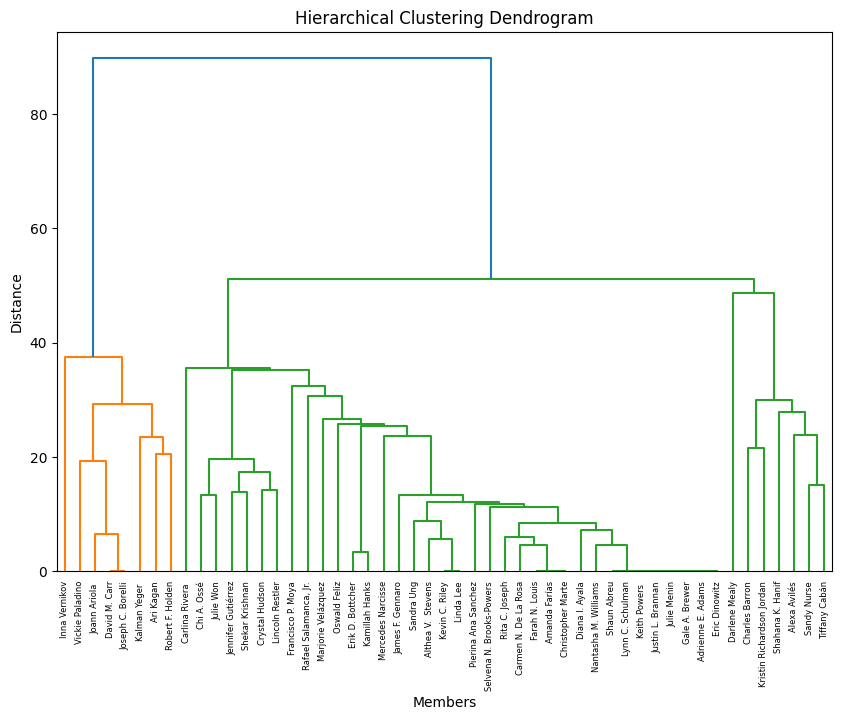

In [410]:
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=one_hot.index, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Members")
plt.ylabel("Distance")
plt.show()

In [411]:
distance_threshold = 35

In [412]:
clusters = fcluster(Z, distance_threshold, criterion='distance')

In [413]:
one_hot['h_cluster'] = clusters

In [416]:
one_hot.reset_index(inplace=True)

In [418]:
cluster_master = one_hot[['VotePersonName', 'h_cluster']].copy()

In [419]:
master = pd.merge(CM_DATA, cluster_master, left_on='OfficeRecordFullName', right_on='VotePersonName', how='left')

In [352]:
gdf = gpd.read_file('../shapefiles/nycc_22a')

In [371]:
gdfe = gdf.to_crs(epsg=4326)

In [421]:
mast = master[['OfficeRecordFullName', 'District', 'h_cluster']].copy()    

In [422]:
master_map = pd.merge(gdfe, mast, left_on='CounDist', right_on='District', how='left')

In [423]:
centroid = master_map.geometry.centroid
mean_lat, mean_lon = centroid.y.mean(), centroid.x.mean()

C:\Users\samtg\AppData\Local\Temp\ipykernel_29848\1443627521.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = master_map.geometry.centroid


In [424]:
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=12)

In [366]:
mean_lat, mean_lon

(202695.70462756744, 1006120.7200228951)

In [425]:
folium.Choropleth(
    geo_data=master_map,
    name='Choropleth',
    data=master_map,
    columns=['CounDist', 'h_cluster'],  # Replace 'data_column' with the name of your column
    key_on='feature.properties.CounDist',
    fill_color='YlGn',  # Choose a color scheme
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Data Legend'  # Replace with your legend name
).add_to(m)

In [427]:
tooltip = GeoJsonTooltip(
    fields=['CounDist', 'OfficeRecordFullName'],  
    aliases=['District: ', 'Member: '],  
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)

In [428]:
folium.GeoJson(
    master_map,
    name='Interactive Tiles',
    tooltip=tooltip
).add_to(m)

In [429]:
folium.LayerControl().add_to(m)

In [430]:
m